# Exploration of the Titanic data set - Load the data

### Prelims

In [2]:
import numpy as np

import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as pp
import matplotlib.cm as cm

import sklearn as sk
import sklearn.model_selection as sk_ms
import sklearn.linear_model as sk_lm

import typing as tp

In [3]:
PICKLE_PATH = '/home/cryo/Documents/github/titanic/prelims/titanic_dataset.pkl'

TITANIC_DF = pd.read_pickle(PICKLE_PATH)

In [4]:
TITANIC_DF.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,343,No,2,"Collander, Mr. Erik Gustaf",male,28.0,0,0,248740,13.0000,NaN,S
1,76,No,3,"Moen, Mr. Sigurd Hansen",male,25.0,0,0,348123,7.6500,F G73,S
2,641,No,3,"Jensen, Mr. Hans Peder",male,20.0,0,0,350050,7.8542,NaN,S


## Labels for the data

In [5]:
def breakdown_by_category(
    df: pd.DataFrame, 
    tgt_feat: str, 
    verbose: bool=True,
    missing_val_word: str='MISSING'
)->tp.Dict[tp.Any, int]:
    """
    Given a dataframe and a feature to target, go through all the values of the feature
    and collate the counts of when feature takes a specific value. Handle missing values
    
    arguments:
    ----------
        df:               the dataframe to analyze
        tgt_feat:         the name of the feature that will be analyzed
        verbose:          print output in addition to returning collated results
        missing_val_word: missing values will be displayed under this name. if the name clashes with a 
                            legitimate value of the feature, an exception will be raised
                            
    returns:
    --------
        a dictionary feature_value->count
    """
    
    # isolate series
    tgt_srs = df[tgt_feat]
    full_row_count = len(tgt_srs)
    
    # storage dictionary
    cat_dict = {}
    
    # handle missing
    no_missing_srs = tgt_srs[tgt_srs.isnull() == 0]
    if len(no_missing_srs) < full_row_count:
        cat_dict[missing_val_word] = full_row_count - len(no_missing_srs)
        
    # if any non-missing rows include them
    if len(no_missing_srs) > 0:
        feat_vocab = no_missing_srs.unique()
        
        # go through all distinct values of the feature
        for feat_word in feat_vocab:
            # avoid clash of the placeholder with legitimate words
            if feat_word == missing_val_word:
                raise Exception(
                    'Legitimate feature word matches the missing value placeholder, change `missing_val_word`'
                )
            
            cat_dict[feat_word] = sum(no_missing_srs==feat_word)
            
    # show output
    if verbose:
        print('Full record count: ', full_row_count)
        print(f'Breakdown by label values of `{tgt_feat}`: ')
        
        for word, count in cat_dict.items():
            print(
                '\t{tgt_feat}==`{word}`: {cur_count} records ({percentage:.1f}% of total)'.format(
                    tgt_feat=tgt_feat,
                    word=word,
                    cur_count=count,
                    percentage=100 * (count/full_row_count)
                )
            )
            
    return cat_dict

In [6]:
LABEL_NAME = 'Survived'

LABEL_BDN_DICT = breakdown_by_category(TITANIC_DF, LABEL_NAME)

Full record count:  891
Breakdown by label values of `Survived`: 
	Survived==`No`: 549 records (61.6% of total)
	Survived==`Yes`: 342 records (38.4% of total)


No unlabeled data - good. Class disbalance not too bad, will use F1 score.

## Features/Label and Train/Test split

In [7]:
# test-train split
TRAIN_DF, TEST_DF = sk_ms.train_test_split(
    TITANIC_DF, train_size=0.6, shuffle=TITANIC_DF[LABEL_NAME]
)

# separate the label
RAW_TRAIN_LABEL = TRAIN_DF.pop(LABEL_NAME).values
RAW_TEST_LABEL = TEST_DF.pop(LABEL_NAME).values

# numeric label
POSITIVE_CLASS_LABEL = 'Yes'
TRAIN_LABEL = np.array(RAW_TRAIN_LABEL==POSITIVE_CLASS_LABEL, dtype=int)
TEST_LABEL = np.array(RAW_TEST_LABEL==POSITIVE_CLASS_LABEL, dtype=int)

## Exploration of features

### Naive classifiers

In [7]:
NAIVE_CLASSIFIERS = {}

#NAIVE_CLASSIFIERS['all_dead'] = lambda features_df: np.zeros(len(features_df), dtype=int)
NAIVE_CLASSIFIERS['all_live'] = lambda features_df: np.ones(len(features_df), dtype=int)

### Feature `Name`

Good [post](https://www.kaggle.com/demidova/titanic-eda-tutorial-with-seaborn/comments) by Nadezhda Demidova suggesting to consider the title as one of the features. Title allows to separate boys from men and married from unmarried women. The main feature is probably the married from un-married

In [31]:
TITLE_LIST = ['Mrs.', 'Mr.', 'Miss.', 'Master.']
OTHER_TITLES = 'Other'

TITLE_COL = np.array([OTHER_TITLES for _ in range(len(TRAIN_DF))])

for chosen_title in TITLE_LIST:
    il_chosen_title = TRAIN_DF.Name.str.contains(chosen_title) & (TITLE_COL==OTHER_TITLES)
    TITLE_COL[il_chosen_title] = chosen_title
    
TITLE_VOCAB = [*TITLE_LIST, OTHER_TITLES]

Text(0, 0.5, 'counts')

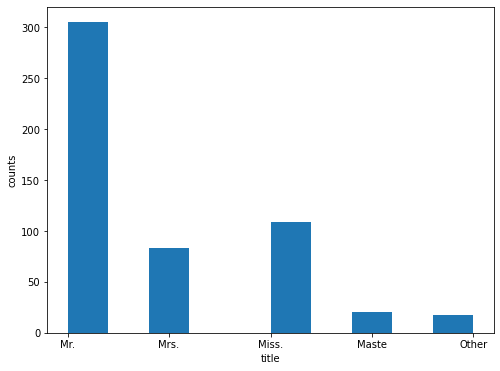

In [29]:
fig, ax = pp.subplots(figsize=(8, 6))

ax.hist(name_col)
ax.set_xlabel('title')
ax.set_ylabel('counts')

What are the survival odds?

In [32]:
for title_val in TITLE_VOCAB:
    il_cur = (TITLE_COL==title_val)
    
    count_lived = sum(TRAIN_LABEL[il_cur] == 1)
    count_perished = sum(TRAIN_LABEL[il_cur] == 0)
    
    if count_perished > 0:
        print(f'title==`{title_val}`: survival_odds = {(count_lived/count_perished):.3f} (full count {sum(il_cur)})')
    else:
        print(f'title==`{title_val}`: survival_odds = invalid (full count {sum(il_cur)})')

title==`Mrs.`: survival_odds = 3.882 (full count 83)
title==`Mr.`: survival_odds = 0.240 (full count 305)
title==`Miss.`: survival_odds = 2.303 (full count 109)
title==`Master.`: survival_odds = invalid (full count 0)
title==`Other`: survival_odds = 0.700 (full count 17)


Both Miss and Mrs have high chances of survival, but the chances are not equal. Should encode it as a feature, but will not make it a navive classifier

### Feature `Pclass`

Passenger class, 1 - upper, 2 - middle, 3 - lower

In [8]:
tgt_feat = 'Pclass'

_ = breakdown_by_category(TRAIN_DF, tgt_feat)

Full record count:  534
Breakdown by label values of `Pclass`: 
	Pclass==`3`: 301 records (56.4% of total)
	Pclass==`1`: 129 records (24.2% of total)
	Pclass==`2`: 104 records (19.5% of total)


Lets compare `Pclass` and the label. How easy is it to predict survival using just this feature? 

In [9]:
tgt_feat = 'Pclass'

pos_dict = breakdown_by_category(TRAIN_DF[TRAIN_LABEL==1], tgt_feat, verbose=False)
neg_dict = breakdown_by_category(TRAIN_DF[TRAIN_LABEL==0], tgt_feat, verbose=False)

for pclass_val in pos_dict.keys():
    print(
        f'class {pclass_val}: survived={pos_dict[pclass_val]},\t perished={neg_dict[pclass_val]}' +\
        f',\t survival odds={pos_dict[pclass_val]/neg_dict[pclass_val]:.3f}'
    )

class 2: survived=55,	 perished=49,	 survival odds=1.122
class 1: survived=73,	 perished=56,	 survival odds=1.304
class 3: survived=69,	 perished=232,	 survival odds=0.297


So a naive classifier would be to say that everyone in first class survived whilst everyone in the third and second class perished.

In [10]:
NAIVE_CLASSIFIERS['naive_Pclass'] = lambda features_df: np.array(features_df.Pclass==1, dtype=int)

### Feature Sex

In [11]:
tgt_feat = 'Sex'

_ = breakdown_by_category(TRAIN_DF, tgt_feat)

Full record count:  534
Breakdown by label values of `Sex`: 
	Sex==`male`: 356 records (66.7% of total)
	Sex==`female`: 178 records (33.3% of total)


No missing labels. Good. Compare sex to label

In [12]:
tgt_feat = 'Sex'

pos_dict = breakdown_by_category(TRAIN_DF[TRAIN_LABEL==1], tgt_feat, verbose=False)
neg_dict = breakdown_by_category(TRAIN_DF[TRAIN_LABEL==0], tgt_feat, verbose=False)

for sex_val in pos_dict.keys():
    print(
        f'{sex_val}: survived={pos_dict[sex_val]},\t perished={neg_dict[sex_val]}' +\
        f',\t survival odds={pos_dict[sex_val]/neg_dict[sex_val]:.3f}'
    )

female: survived=136,	 perished=42,	 survival odds=3.238
male: survived=61,	 perished=295,	 survival odds=0.207


So females had much better odds of survival. Naive classifier would be to kill all men, and let females live

In [13]:
NAIVE_CLASSIFIERS['naive_Sex'] = lambda features_df: np.array(features_df.Sex=='female', dtype=int)

### Feature Age

In [14]:
IL_AGE_MISSING = TRAIN_DF.Age.isnull()

print('{} out of {} records are missing age'.format(IL_AGE_MISSING.sum(), len(TRAIN_DF)))

no_age_survived = sum(TRAIN_LABEL[IL_AGE_MISSING]==1)
no_age_perished = sum(TRAIN_LABEL[IL_AGE_MISSING]==0)

print(f'Survival odds for those missing age: {(no_age_survived/no_age_perished):.3f}')

120 out of 534 records are missing age
Survival odds for those missing age: 0.379


So missing age is not a bad predictor for dying. What is the spread for other ages?

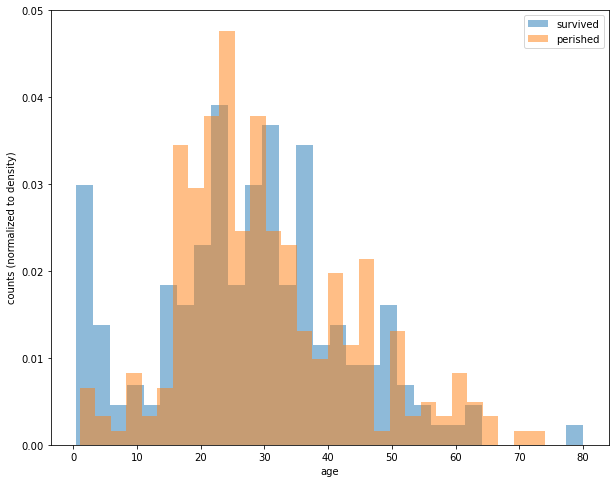

In [15]:
present_age_range = TRAIN_DF.Age[IL_AGE_MISSING==0].values
present_label_range = TRAIN_LABEL[IL_AGE_MISSING==0]

fig, ax = pp.subplots(figsize=(10, 8))
_ = ax.hist(present_age_range[present_label_range==1], alpha=0.5, label='survived', density=True, bins=30)
_ = ax.hist(present_age_range[present_label_range==0], alpha=0.5, label='perished', density=True, bins=30)
ax.set_xlabel('age')
ax.set_ylabel('counts (normalized to density)')
_ = ax.legend()

There does not seem to be a strong selection by age in terms of who survived, with the exception of children. Tried logistic regresion, not much luck. Will set a simple rule that anyone older than 10 years dies. 

All the missing cases die as well, but treat them separately since there is no obvious change difference in distribution for survived and perished for older ages. **A proper way to handle it, later on, is to set all the missing ages to ????, and then have a separate column for missing values**

In [16]:
NAIVE_CLASSIFIERS['naive_Age'] = lambda features_df: np.array(features_df.Age<10, dtype=int)

### Feature SibSp

Number of siblings and spouses aboard.

In [17]:
tgt_feat = 'SibSp'

_ = breakdown_by_category(TITANIC_DF, tgt_feat)

Full record count:  891
Breakdown by label values of `SibSp`: 
	SibSp==`0`: 608 records (68.2% of total)
	SibSp==`1`: 209 records (23.5% of total)
	SibSp==`2`: 28 records (3.1% of total)
	SibSp==`3`: 16 records (1.8% of total)
	SibSp==`5`: 5 records (0.6% of total)
	SibSp==`4`: 18 records (2.0% of total)
	SibSp==`8`: 7 records (0.8% of total)


Seems to be no missing records for this feature. The main two categories are `0` and `1`. What are the survival odds?

In [18]:
sibsp_vocab = TITANIC_DF.SibSp.unique()

for sibsp_val in sibsp_vocab:
    il_cur = (TRAIN_DF.SibSp==sibsp_val).values
    
    count_lived = sum(TRAIN_LABEL[il_cur] == 1)
    count_perished = sum(TRAIN_LABEL[il_cur] == 0)
    
    if count_perished > 0:
        print(f'SibSp==`{sibsp_val}`: survival_odds = {(count_lived/count_perished):.3f} (full count {sum(il_cur)})')
    else:
        print(f'SibSp==`{sibsp_val}`: survival_odds = invalid (full count {sum(il_cur)})')

SibSp==`0`: survival_odds = 0.508 (full count 380)
SibSp==`1`: survival_odds = 1.035 (full count 116)
SibSp==`2`: survival_odds = 0.875 (full count 15)
SibSp==`3`: survival_odds = 0.500 (full count 9)
SibSp==`5`: survival_odds = 0.000 (full count 4)
SibSp==`4`: survival_odds = 0.000 (full count 6)
SibSp==`8`: survival_odds = 0.000 (full count 4)


Naive classifier would be to set all with SibSp==1 to survive, all others die

In [19]:
NAIVE_CLASSIFIERS['naive_SibSp'] = lambda features_df: np.array(features_df.SibSp==1, dtype=int)

### Feature `Parch`

Number of parents and children

In [20]:
tgt_feat = 'Parch'

_ = breakdown_by_category(TITANIC_DF, tgt_feat)

Full record count:  891
Breakdown by label values of `Parch`: 
	Parch==`0`: 678 records (76.1% of total)
	Parch==`4`: 4 records (0.4% of total)
	Parch==`2`: 80 records (9.0% of total)
	Parch==`1`: 118 records (13.2% of total)
	Parch==`5`: 5 records (0.6% of total)
	Parch==`6`: 1 records (0.1% of total)
	Parch==`3`: 5 records (0.6% of total)


Most people have zero, so not expecting this to give good prediction results on its own

In [21]:
parch_vocab = TITANIC_DF.Parch.unique()

for parch_val in parch_vocab:
    il_cur = (TRAIN_DF.Parch==parch_val).values
    
    count_lived = sum(TRAIN_LABEL[il_cur] == 1)
    count_perished = sum(TRAIN_LABEL[il_cur] == 0)
    
    if count_perished > 0:
        print(f'Parch==`{parch_val}`: survival_odds = {(count_lived/count_perished):.3f} (full count {sum(il_cur)})')
    else:
        print(f'Parch==`{parch_val}`: survival_odds = invalid (full count {sum(il_cur)})')

Parch==`0`: survival_odds = 0.463 (full count 417)
Parch==`4`: survival_odds = 0.000 (full count 2)
Parch==`2`: survival_odds = 1.190 (full count 46)
Parch==`1`: survival_odds = 1.520 (full count 63)
Parch==`5`: survival_odds = 0.000 (full count 2)
Parch==`6`: survival_odds = invalid (full count 0)
Parch==`3`: survival_odds = 1.000 (full count 4)


Again, it seems that the best thing to set all with Parch==1 to live, others die

In [22]:
NAIVE_CLASSIFIERS['naive_Parch'] = lambda features_df: np.array(features_df.Parch==1, dtype=int)

### Feature Fare

In [23]:
print(f'Number of records with missing fares: {sum(TITANIC_DF.Fare.isnull())}')

Number of records with missing fares: 0


No problems with missing data - good. What is the distribution of fares between those who lived and those who perished?

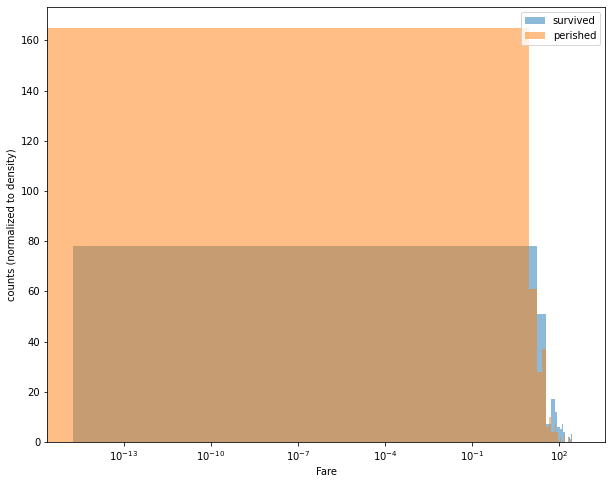

In [24]:
fig, ax = pp.subplots(figsize=(10, 8))
_ = ax.hist(TRAIN_DF[TRAIN_LABEL==1].Fare, alpha=0.5, label='survived', bins=30)
_ = ax.hist(TRAIN_DF[TRAIN_LABEL==0].Fare, alpha=0.5, label='perished', bins=30)
ax.set_xlabel('Fare')
ax.set_ylabel('counts (normalized to density)')
_ = ax.legend()
ax.set_xscale('log')

A reasonable threshold seems that fares below 9 perish, above live

In [25]:
NAIVE_CLASSIFIERS['naive_Fare'] = lambda features_df: np.array(features_df.Fare>9, dtype=int)

### Feature Cabin

In [26]:
tgt_feat = 'Cabin'

_ = breakdown_by_category(TITANIC_DF, tgt_feat)

Full record count:  891
Breakdown by label values of `Cabin`: 
	Cabin==`MISSING`: 687 records (77.1% of total)
	Cabin==`F G73`: 2 records (0.2% of total)
	Cabin==`B71`: 1 records (0.1% of total)
	Cabin==`C82`: 1 records (0.1% of total)
	Cabin==`C93`: 2 records (0.2% of total)
	Cabin==`B41`: 1 records (0.1% of total)
	Cabin==`C95`: 1 records (0.1% of total)
	Cabin==`B38`: 1 records (0.1% of total)
	Cabin==`C52`: 2 records (0.2% of total)
	Cabin==`A32`: 1 records (0.1% of total)
	Cabin==`C111`: 1 records (0.1% of total)
	Cabin==`C2`: 2 records (0.2% of total)
	Cabin==`E101`: 3 records (0.3% of total)
	Cabin==`C83`: 2 records (0.2% of total)
	Cabin==`C22 C26`: 3 records (0.3% of total)
	Cabin==`C47`: 1 records (0.1% of total)
	Cabin==`B58 B60`: 2 records (0.2% of total)
	Cabin==`E38`: 1 records (0.1% of total)
	Cabin==`D15`: 1 records (0.1% of total)
	Cabin==`T`: 1 records (0.1% of total)
	Cabin==`C54`: 1 records (0.1% of total)
	Cabin==`C103`: 1 records (0.1% of total)
	Cabin==`C125`: 2 

It makes more sense to convert cabin to a categorical feature - MISSING, 1 Ocurrance, More than 1 Ocurrance

In [27]:
def CABIN_TO_CAT(cabin_srs: pd.Series)->pd.Series:
    """
    Given cabin series convert each cabin to the number of times it occurs in the list
    give 0 for missing values
    """
    cabin_dict = breakdown_by_category(pd.DataFrame(cabin_srs), cabin_srs.name, verbose=False)
    
    new_cabin_list = []
    
    for i_cab, cur_cab_val in enumerate(cabin_srs):
        if type(cur_cab_val) == str:
            cur_val = cabin_dict[cur_cab_val]
        else:
            cur_val = 0
        
        new_cabin_list.append(cur_val)
            
    return pd.Series(new_cabin_list)

# what are the odds of survival based on cat_cabin representation
TRAIN_CAT_CABIN_SRS = CABIN_TO_CAT(TRAIN_DF.Cabin)

cat_cabin_vocab = TRAIN_CAT_CABIN_SRS.unique()

for cat_cabin_val in cat_cabin_vocab:
    il_cur = (TRAIN_CAT_CABIN_SRS==cat_cabin_val).values
    
    count_lived = sum(TRAIN_LABEL[il_cur] == 1)
    count_perished = sum(TRAIN_LABEL[il_cur] == 0)
    
    if count_perished > 0:
        print(f'cat_cabin==`{cat_cabin_val}`: survival_odds = {(count_lived/count_perished):.3f} (full count {sum(il_cur)})')
    else:
        print(f'cat_cabin==`{cat_cabin_val}`: survival_odds = invalid (full count {sum(il_cur)})')

cat_cabin==`0`: survival_odds = 0.434 (full count 413)
cat_cabin==`1`: survival_odds = 1.222 (full count 80)
cat_cabin==`2`: survival_odds = 1.889 (full count 26)
cat_cabin==`3`: survival_odds = 2.750 (full count 15)


It would seem that survival odds for those with missing cabins were significantly lower than for those with cabins. Also it seems that odds of survival increased, with the more people there were per cabin, but it is hard to compare due to very different record distribution

In [28]:
NAIVE_CLASSIFIERS['naive_Cabin'] = lambda features_df: np.array(features_df.Cabin.isnull()==False, dtype=int)

Another approach is to consider the deck of the ticket.

In [29]:
def CABIN_TO_DECK(cabin_srs: pd.Series)->pd.Series:
    res = pd.Series([
        cab[0] if (type(cab)==str and len(cab)>0) else 'MISSING' for cab in cabin_srs
    ])
    #
    res.name = 'deck'
    return res
    
###############

deck_srs = CABIN_TO_DECK(TRAIN_DF.Cabin)
deck_vocab = deck_srs.unique()

for deck_name in deck_vocab:
    count_lived = sum( TRAIN_LABEL[deck_srs == deck_name] == 1 )
    count_perished = sum( TRAIN_LABEL[deck_srs == deck_name] == 0 )
    
    if count_perished > 0:
        print(f'deck==`{deck_name}`: survival_odds = {(count_lived/count_perished):.3f} (full count {count_lived + count_perished})')
    else:
        print(f'deck==`{deck_name}`: survival_odds = invalid (full count {count_lived + count_perished})')

deck==`MISSING`: survival_odds = 0.434 (full count 413)
deck==`A`: survival_odds = 1.333 (full count 7)
deck==`D`: survival_odds = 2.000 (full count 21)
deck==`F`: survival_odds = 1.200 (full count 11)
deck==`C`: survival_odds = 0.750 (full count 35)
deck==`B`: survival_odds = 2.111 (full count 28)
deck==`E`: survival_odds = 3.500 (full count 18)
deck==`G`: survival_odds = 0.000 (full count 1)


So the worst odds of survival are for the missing decks `MISSING` and `A`

In [30]:
def naive_deck_classifier(features_df: pd.Series)->np.ndarray:
    cabin_srs = CABIN_TO_DECK(features_df.Cabin)
    
    pred_survived = np.ones(len(cabin_srs), dtype=int)
    pred_survived[cabin_srs == 'MISSING'] = 0
    pred_survived[cabin_srs == 'A'] = 0
    pred_survived[cabin_srs == 'F'] = 0
    
    return pred_survived

NAIVE_CLASSIFIERS['naive_Deck'] = naive_deck_classifier

### Feature Embarked

Place from which people embarked: C = Cherbourg, Q = Queenstown, S = Southampton

In [31]:
tgt_feat = 'Embarked'

_ = breakdown_by_category(TITANIC_DF, tgt_feat)

Full record count:  891
Breakdown by label values of `Embarked`: 
	Embarked==`MISSING`: 2 records (0.2% of total)
	Embarked==`S`: 644 records (72.3% of total)
	Embarked==`C`: 168 records (18.9% of total)
	Embarked==`Q`: 77 records (8.6% of total)


Just two records missing, so not too important to worry about them here

In [32]:
# fill missing
TRAIN_IMP_EMBARKED = TRAIN_DF.Embarked.fillna(value='M')
embarked_vocab = TRAIN_IMP_EMBARKED.unique()

for embarked_val in embarked_vocab:
    il_cur = (TRAIN_IMP_EMBARKED==embarked_val).values
    
    count_lived = sum(TRAIN_LABEL[il_cur] == 1)
    count_perished = sum(TRAIN_LABEL[il_cur] == 0)
    
    if count_perished > 0:
        print(f'EMBARKED==`{embarked_val}`: survival_odds = {(count_lived/count_perished):.3f} (full count {sum(il_cur)})')
    else:
        print(f'EMBARKED==`{embarked_val}`: survival_odds = invalid (full count {sum(il_cur)})')

EMBARKED==`C`: survival_odds = 0.980 (full count 99)
EMBARKED==`S`: survival_odds = 0.502 (full count 383)
EMBARKED==`Q`: survival_odds = 0.562 (full count 50)
EMBARKED==`M`: survival_odds = invalid (full count 2)


One can see that, compared to others, people from Cherbourg had much better chance of survival

In [33]:
NAIVE_CLASSIFIERS['naive_Embarked'] = lambda features_df: np.array(features_df.Embarked=='C', dtype=int)

## Test naive classifiers

            all_live: 	prec=0.406, rec=1.000
        naive_Pclass: 	prec=0.724, rec=0.434
           naive_Sex: 	prec=0.713, rec=0.669
           naive_Age: 	prec=0.536, rec=0.103
         naive_SibSp: 	prec=0.570, rec=0.366
         naive_Parch: 	prec=0.491, rec=0.186
          naive_Fare: 	prec=0.482, rec=0.821
         naive_Cabin: 	prec=0.771, rec=0.441
          naive_Deck: 	prec=0.808, rec=0.407
      naive_Embarked: 	prec=0.638, rec=0.303
       random_chance: 	prec=0.406, rec=0.500


(-0.05, 1.05)

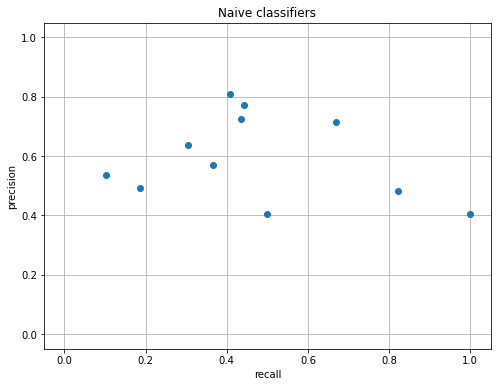

In [34]:
naive_prec_rec_dict_list = []

for nc_name, nc_func in NAIVE_CLASSIFIERS.items():
    predicted_label = nc_func(TEST_DF)
    
    precision, recall, _, _ = sk.metrics.precision_recall_fscore_support(y_true=TEST_LABEL, y_pred=predicted_label, average='binary')
    print(f'{nc_name:>20}: \tprec={precision:.3f}, rec={recall:.3f}')
    
    naive_prec_rec_dict_list.append({
        'nc_name': nc_name,
        'precision': precision,
        'recall': recall
    })
    
# extra one for random chance
rnd_name = 'random_chance'
rnd_prec = sum(TEST_LABEL)/len(TEST_LABEL)
rnd_rec = 0.5
naive_prec_rec_dict_list.append({
        'nc_name': 'random_chance',
        'precision': rnd_prec,
        'recall': rnd_rec
    })
print(f'{rnd_name:>20}: \tprec={rnd_prec:.3f}, rec={rnd_rec:.3f}')
    
naive_prec_rec_df = pd.DataFrame(naive_prec_rec_dict_list)
naive_prec_rec_df.to_pickle('naive_precision_recall.pkl')
# plot the naive classifiers
fig, ax = pp.subplots(figsize=(8, 6))

ax.plot(naive_prec_rec_df.recall, naive_prec_rec_df.precision, 'o')
ax.set_xlabel('recall')
ax.set_ylabel('precision')
ax.grid()
ax.set_title('Naive classifiers')
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])